In [0]:
# Basic imports
import random
import time
import pandas as pd
import numpy as np

# Visualization imports
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import missingno as msno

# Split train and test
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

# Feature Engineering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier

# Regression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# Otimization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Scores Classification
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Scores Regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# Final Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Export model
import pickle

#Colab imports
from google.colab import files

In [55]:
df = pd.read_csv("/content/dados_clima.csv", sep=';')
cod_ventos = pd.read_csv("/content/ventos.csv", sep=',')
print("Dataset has {} entries and {} features".format(*df.shape))

Dataset has 48591 entries and 19 features


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48591 entries, 0 to 48590
Data columns (total 19 columns):
Estacao                      48591 non-null int64
Data                         48591 non-null object
Hora                         48591 non-null int64
Precipitacao                 16227 non-null float64
TempBulboSeco                46996 non-null float64
TempBulboUmido               46926 non-null float64
TempMaxima                   15960 non-null float64
TempMinima                   16153 non-null float64
UmidadeRelativa              46527 non-null float64
PressaoAtmEstacao            47010 non-null float64
PressaoAtmMar                19680 non-null float64
DirecaoVento                 47029 non-null float64
VelocidadeVento              46973 non-null float64
Insolação                    15780 non-null float64
Nebulosidade                 48101 non-null float64
Evaporacao Piche             15413 non-null float64
Temp Comp Media              15361 non-null float64
Umidade Rela

In [57]:
df = df.join(cod_ventos, on='DirecaoVento').drop(['codigo', ' descrição'], axis=1)
df["DirecaoVento"] = df[" sigla"]
df.drop([" sigla"], axis=1, inplace=True)
df

,Estacao,Data,Hora,Precipitacao,TempBulboSeco,TempBulboUmido,TempMaxima,TempMinima,UmidadeRelativa,PressaoAtmEstacao,PressaoAtmMar,DirecaoVento,VelocidadeVento,Insolação,Nebulosidade,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
0,82598,01/01/1961,0,NaN,NaN,NaN,30.4,NaN,NaN,NaN,NaN,NaN,NaN,11.7,NaN,10.6,27.30,68.75,7.00000
1,82598,01/01/1961,1200,NaN,28.4,23.4,NaN,24.5,64.0,1010.8,NaN,E,9.00000,NaN,4.00,NaN,NaN,NaN,NaN
2,82598,01/01/1961,1800,NaN,28.8,24.5,NaN,NaN,69.0,1008.0,NaN,E,5.00000,NaN,2.00,NaN,NaN,NaN,NaN
3,82598,02/01/1961,0,NaN,26.6,22.8,30.3,NaN,71.0,1010.7,NaN,E,7.00000,7.0,2.00,8.6,26.74,74.00,7.00000
4,82598,02/01/1961,1200,0.0,26.2,23.8,NaN,24.4,81.0,1011.6,NaN,E,5.00000,NaN,10.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48586,82598,07/10/19,1800,NaN,27.7,NaN,NaN,NaN,66.0,1007.3,1012.6,SE,8.23104,NaN,7.50,NaN,NaN,NaN,NaN
48587,82598,08/10/19,0,NaN,25.9,NaN,29.8,NaN,77.0,1010.3,1015.6,SE,4.62996,10.7,6.25,NaN,27.04,73.00,8.05956
48588,82598,08/10/19,1200,0.0,28.1,NaN,NaN,25.1,62.0,1009.9,1015.2,SE,9.25992,NaN,7.50,NaN,NaN,NaN,NaN
48589,82598,08/10/19,1800,NaN,28.2,NaN,NaN,NaN,67.0,1006.8,1012.1,SE,8.23104,NaN,2.50,NaN,NaN,NaN,NaN


In [0]:
df["Data"] = pd.to_datetime(df['Data'])

In [0]:
df['Day'] = df['Data'].dt.day
df['Month'] = df['Data'].dt.month
df['Year'] = df['Data'].dt.year

df['Week'] = df['Data'].dt.week
df['DayOfWeek'] = df['Data'].dt.dayofweek

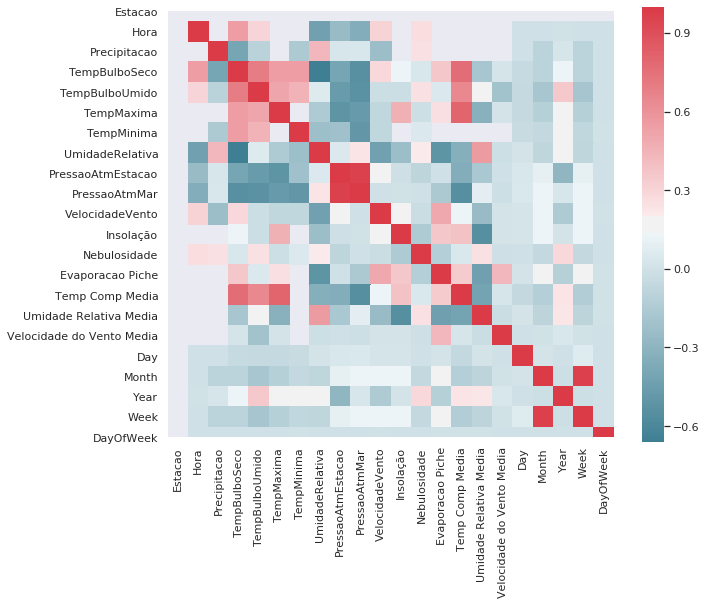

In [60]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), mask=np.zeros_like(df.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

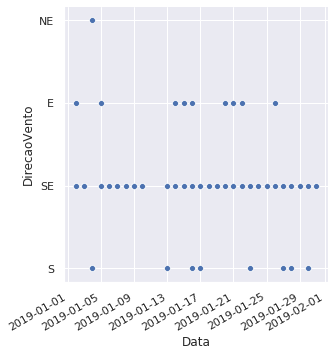

In [61]:
g = sns.relplot(x="Data",
                y="DirecaoVento",
#                data=df[df['Data'] < pd.Timestamp('2018-04-01')], kind="line",
                data=df[np.logical_and(df['Data'] > pd.Timestamp('2019-01-01'), df['Data'] < pd.Timestamp('2019-02-01')) ],                
                #style="Hora", height=10
                )
g.fig.autofmt_xdate()

In [0]:
data = df.loc[pd.notnull(df['DirecaoVento'])].copy()

In [0]:
#data = pd.concat([data, pd.get_dummies(data, prefix="VentoDir", columns=["DirecaoVento"], drop_first=True)])

In [0]:
#data.drop(['DirecaoVento'], axis=1, inplace=True)

In [65]:
data

,Estacao,Data,Hora,Precipitacao,TempBulboSeco,TempBulboUmido,TempMaxima,TempMinima,UmidadeRelativa,PressaoAtmEstacao,PressaoAtmMar,DirecaoVento,VelocidadeVento,Insolação,Nebulosidade,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Day,Month,Year,Week,DayOfWeek
1,82598,1961-01-01,1200,NaN,28.4,23.4,NaN,24.5,64.0,1010.8,NaN,E,9.00000,NaN,4.00,NaN,NaN,NaN,NaN,1,1,1961,52,6
2,82598,1961-01-01,1800,NaN,28.8,24.5,NaN,NaN,69.0,1008.0,NaN,E,5.00000,NaN,2.00,NaN,NaN,NaN,NaN,1,1,1961,52,6
3,82598,1961-02-01,0,NaN,26.6,22.8,30.3,NaN,71.0,1010.7,NaN,E,7.00000,7.0,2.00,8.6,26.74,74.0,7.00000,1,2,1961,5,2
4,82598,1961-02-01,1200,0.0,26.2,23.8,NaN,24.4,81.0,1011.6,NaN,E,5.00000,NaN,10.00,NaN,NaN,NaN,NaN,1,2,1961,5,2
5,82598,1961-02-01,1800,NaN,28.7,23.8,NaN,NaN,65.0,1009.0,NaN,E,9.00000,NaN,3.00,NaN,NaN,NaN,NaN,1,2,1961,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48586,82598,2019-07-10,1800,NaN,27.7,NaN,NaN,NaN,66.0,1007.3,1012.6,SE,8.23104,NaN,7.50,NaN,NaN,NaN,NaN,10,7,2019,28,2
48587,82598,2019-08-10,0,NaN,25.9,NaN,29.8,NaN,77.0,1010.3,1015.6,SE,4.62996,10.7,6.25,NaN,27.04,73.0,8.05956,10,8,2019,32,5
48588,82598,2019-08-10,1200,0.0,28.1,NaN,NaN,25.1,62.0,1009.9,1015.2,SE,9.25992,NaN,7.50,NaN,NaN,NaN,NaN,10,8,2019,32,5
48589,82598,2019-08-10,1800,NaN,28.2,NaN,NaN,NaN,67.0,1006.8,1012.1,SE,8.23104,NaN,2.50,NaN,NaN,NaN,NaN,10,8,2019,32,5


In [0]:
# Random value for states
random_state = 42

# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels="DirecaoVento",axis=1),
                                                    data["DirecaoVento"],
                                                    test_size=0.30,
                                                    random_state=random_state,
                                                    shuffle=True)

In [0]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ] 

In [68]:
target_variables = list(X_train.columns)
DateTime_variables = ['Data', 'Day', 'Month', 'Year', 'Week', 'DayOfWeek']

for col in DateTime_variables:
  target_variables.remove(col)

print(target_variables)
# Defining the steps in the numerical pipeline

#numerical_features = target_variables+DateTime_variables

numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(target_variables)),
                                       ('std_imputer', SimpleImputer(np.NaN, "mean")) 
                                       ]
                              )
# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [
                                                               ('numerical_pipeline', numerical_pipeline)
                                                              ]
                                          )

['Estacao', 'Hora', 'Precipitacao', 'TempBulboSeco', 'TempBulboUmido', 'TempMaxima', 'TempMinima', 'UmidadeRelativa', 'PressaoAtmEstacao', 'PressaoAtmMar', 'VelocidadeVento', 'Insolação', 'Nebulosidade', 'Evaporacao Piche', 'Temp Comp Media', 'Umidade Relativa Media', 'Velocidade do Vento Media']


In [0]:
target_variables = ['Hora', 'TempBulboSeco', 'TempBulboUmido', 'TempMinima', 'UmidadeRelativa', 'PressaoAtmEstacao', 'Precipitacao' ,'Nebulosidade']
DateTime_variables = ['Day', 'Month', 'Year', 'Week', 'DayOfWeek']

# Defining the steps in the numerical pipeline

numerical_features = target_variables+DateTime_variables

numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('std_imputer', SimpleImputer(np.NaN, "mean")) 
                                       ]
                              )
# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [
                                                               ('numerical_pipeline', numerical_pipeline)
                                                              ]
                                          )

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32920 entries, 41432 to 16312
Data columns (total 23 columns):
Estacao                      32920 non-null int64
Data                         32920 non-null datetime64[ns]
Hora                         32920 non-null int64
Precipitacao                 10954 non-null float64
TempBulboSeco                32146 non-null float64
TempBulboUmido               32059 non-null float64
TempMaxima                   10769 non-null float64
TempMinima                   10912 non-null float64
UmidadeRelativa              31818 non-null float64
PressaoAtmEstacao            32111 non-null float64
PressaoAtmMar                13058 non-null float64
VelocidadeVento              32881 non-null float64
Insolação                    10625 non-null float64
Nebulosidade                 32890 non-null float64
Evaporacao Piche             10355 non-null float64
Temp Comp Media              10425 non-null float64
Umidade Relativa Media       10422 non-null float64


In [71]:
X_train.head()

,Estacao,Data,Hora,Precipitacao,TempBulboSeco,TempBulboUmido,TempMaxima,TempMinima,UmidadeRelativa,PressaoAtmEstacao,PressaoAtmMar,VelocidadeVento,Insolação,Nebulosidade,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Day,Month,Year,Week,DayOfWeek
41432,82598,2013-03-25,0,NaN,27.2,24.6,31.0,NaN,81.0,1006.7,1012.0,3.3,0.5,3.0,5.1,27.76,79.25,3.866667,25,3,2013,13,0
36061,82598,2008-04-29,1800,NaN,29.4,25.4,NaN,NaN,71.0,1002.6,1007.9,5.0,NaN,5.0,NaN,NaN,NaN,NaN,29,4,2008,18,1
15313,82598,1989-01-18,0,NaN,26.6,24.0,30.0,NaN,81.0,1008.3,NaN,3.6,11.1,3.0,5.8,27.32,72.75,3.766667,18,1,1989,3,2
31993,82598,2004-12-08,1800,NaN,26.6,24.0,NaN,NaN,81.0,1010.6,1015.9,5.8,NaN,10.0,NaN,NaN,NaN,NaN,8,12,2004,50,2
16474,82598,1990-04-13,1200,0.0,28.8,25.4,NaN,23.5,75.0,1008.9,NaN,4.1,NaN,7.0,NaN,NaN,NaN,NaN,13,4,1990,15,4


In [72]:
num_folds = 4
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold

# The full pipeline as a step in another pipeline with an estimator as the final step
pipe = Pipeline(steps = [
                         ('full_pipeline', full_pipeline_preprocessing),
                         ("clf", XGBClassifier())
                        ]
                )

search_space = [
                {
                 "clf":[XGBClassifier()],
                 "clf__n_estimators": [10, 50, 100],
                 "clf__max_depth": [1, 2, 3],
                 "clf__learning_rate": [0.2, 0.25, 0.3],
                 #"clf__random_state": [42, 21],
                 #"clf__subsample": [0.8, 0.9, 1.0],
                 #"clf__colsample_bytree": [0.8, 0.9, 1.0],
                 "clf__n_jobs": [-1]
                 },
                {
                 "clf":[DecisionTreeClassifier()],
                 "clf__criterion": ["gini","entropy"]
                 },
                 {
                 "clf": [KNeighborsClassifier()],
                 "clf__n_neighbors": [5,7]
                 }
                ]

kfold = KFold(n_splits=num_folds, random_state=42)

grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    return_train_score=True,
                    n_jobs=-1)

tmp = time.time()

best_model = grid.fit(X_train[DateTime_variables + target_variables].copy(), y_train)

print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))

CPU Training Time: 485.90456771850586 seconds


In [25]:
print("Best: %.4f using %s" % (best_model.best_score_,best_model.best_params_))

Best: 0.6572 using {'clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__n_jobs': -1}


In [26]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,param_clf__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.213214,0.118126,0.025003,0.000964,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,1,10,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.612394,0.610875,0.627582,0.611786,0.613001,0.601762,0.603281,0.619077,0.613609,0.601458,0.611482,0.007663,27,0.611381,0.611584,0.609727,0.611482,0.611314,0.612495,0.612326,0.610672,0.611246,0.612630,0.611486,0.000830
1,5.298093,0.054899,0.075168,0.001148,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,1,50,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.620292,0.620899,0.639429,0.621507,0.626974,0.616950,0.610267,0.627886,0.623937,0.611482,0.621962,0.008031,22,0.623431,0.622958,0.620967,0.623059,0.622688,0.623566,0.624038,0.622485,0.622992,0.623734,0.622992,0.000814
2,10.343483,0.079680,0.145712,0.001094,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,1,100,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.622114,0.621810,0.644289,0.619988,0.631835,0.619077,0.616039,0.633657,0.624544,0.619380,0.625273,0.008269,17,0.627008,0.627143,0.624713,0.627211,0.626266,0.627244,0.627751,0.626468,0.627042,0.626873,0.626772,0.000790
3,1.575659,0.033631,0.028441,0.000336,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,2,10,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.623633,0.617558,0.639733,0.620595,0.625152,0.617254,0.610267,0.625759,0.623633,0.611482,0.621507,0.007962,24,0.623296,0.622283,0.620393,0.622317,0.621675,0.623498,0.622857,0.622553,0.622891,0.623262,0.622502,0.000877
4,7.887451,0.119910,0.101896,0.001639,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,2,50,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.626671,0.628797,0.648542,0.626974,0.634569,0.633354,0.625456,0.635176,0.630012,0.628493,0.631804,0.006440,12,0.637134,0.636256,0.635412,0.636425,0.635851,0.636695,0.636155,0.634670,0.636931,0.635244,0.636077,0.000745
5,16.143850,0.213856,0.224764,0.008574,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,2,100,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.636999,0.638821,0.660085,0.633961,0.643074,0.640948,0.635176,0.643682,0.643682,0.642163,0.641859,0.006936,9,0.651512,0.648981,0.649149,0.649757,0.649217,0.650803,0.648981,0.648542,0.647597,0.648643,0.649318,0.001072
6,2.040473,0.021857,0.031829,0.000507,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,3,10,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.621810,0.621507,0.636391,0.623026,0.629405,0.621810,0.616039,0.630620,0.625759,0.619684,0.624605,0.005699,18,0.629776,0.627953,0.624781,0.629202,0.627751,0.626637,0.627481,0.627920,0.628696,0.628392,0.627859,0.001327
7,10.584650,0.066933,0.123949,0.001104,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,3,50,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.636391,0.640644,0.663123,0.640644,0.648542,0.637303,0.642467,0.650668,0.648542,0.646416,0.645474,0.007504,7,0.656879,0.653436,0.654381,0.656440,0.655225,0.655799,0.655191,0.653503,0.653942,0.655596,0.655039,0.001134
8,21.614793,0.110721,0.285953,0.011500,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,3,100,-1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.637910,0.650365,0.664945,0.648846,0.654617,0.648846,0.652491,0.655225,0.660693,0.655225,0.652916,0.006955,3,0.672843,0.669333,0.671223,0.669839,0.670413,0.671358,0.672371,0.669772,0.670953,0.670211,0.670832,0.001085
9,1.134156,0.011462,0.024

In [27]:
pred = best_model.predict(X_test)
accuracy_score(y_test, pred)

0.6510737826918988

In [30]:
confusion_matrix(y_test, pred)

array([[ 228,   12,    0,    0,    0,    0,    0,    0,   51,  152,    0,
           0,    0],
       [  14,  717,    0,    0,    1,    0,    0,    1,   43, 2213,    0,
           1,    0],
       [   0,    1,    0,    0,    0,    0,    0,    0,    0,    2,    0,
           0,    0],
       [   0,    5,    0,    0,    0,    0,    0,    0,    5,   14,    0,
           0,    0],
       [   4,   65,    0,    0,    0,    0,    0,    0,    4,  211,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    2,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0],
       [   0,    2,    0,    0,    0,    0,    0,    0,    1,   13,    0,
           0,    0],
       [  35,   12,    0,    0,    1,    0,    0,    0,  643, 1059,    0,
           2,    0],
       [ 102,  479,    0,    0,    0,    0,    0,    0,  351, 7596,    0,
           2,    0],
       [   0,    0,    0,    0,    0,    0,    0, 

In [31]:
pd.DataFrame({"Originais":y_test.values, "Predições":pred})

,Originais,Predições
0,NE,SE
1,E,SE
2,C,SE
3,SE,SE
4,S,S
...,...,...
14104,SE,SE
14105,SE,SE
14106,SE,SE
14107,E,SE
